# Lesson 1  
## Exercise 01.1  
Verification of the correct functioning of the pseudo-random number generator provided, contained in the folder `../../Library/PNRG/`, in the files `random.h` and `random.cpp`. For this purpose, it is useful to calculate the mean value of $r$, a variable representing a (pseudo)random number generated uniformly in the interval $[0,1)$ using the `Rannyu` method from the `Random` class.  

To achieve this, I developed the file `main.cpp`. In this file, I set up the data to verify:  

1. $\langle r \rangle = \int_0^1 r \, dr = 1/2$. I then created a plot with the estimate of $\langle r \rangle$ and its uncertainty, i.e., the standard deviation of the mean for a number of throws $M \geq 10^4$ divided into $N$ blocks. As suggested in class, I used the **blocking method**.  

In computing the statistical uncertainties, i.e., the standard deviation of the mean, you need an estimation of the variance $\sigma^2$, the second central moment. First of all, note that the variance can be computed from  

$$\sigma^2_A := \langle (A-\langle A\rangle)^2\rangle = \langle A^2 \rangle -\langle A\rangle^2$$

What is the best way to estimate $\sigma^2_A$? Imagine that your Monte Carlo estimation of $A$ is obtained from a calculation that uses $M$ Monte Carlo "steps" (intentionally, here I am generic because what is a single "step" in a Monte Carlo calculation strictly depends on the specific calculation); you can always divide such $M$ Monte Carlo "steps" into $N$ blocks, with $N < M$. In each block, you can use your $M/N$ Monte Carlo "steps" to obtain an estimate of $A$, let me call it $A_i$ (mean of the block) with $i = 1, \ldots, N$, and then you also have $A^2_i$ with $i = 1, \ldots, N$.  

At this point, everything becomes clear:  

$$\langle A^2 \rangle \simeq \frac{1}{N} \sum_{i=1}^N A^2_i \quad \quad \langle A\rangle^2 \simeq \left( \frac{1}{N} \sum_{i=1}^N A_i \right)^2$$

and finally the statistical uncertainty with $N$, number of blocks:  

$$\frac{\sigma}{\sqrt{N-1}} \simeq \sqrt{\frac{1}{N-1} \left[ \frac{1}{N} \sum_{i=1}^N A^2_i - \left( \frac{1}{N} \sum_{i=1}^N A_i \right)^2 \right]}$$

So I perform all the statistics with the blocks.  

2. $\sigma^2 = \int_0^1 (r-1/2)^2 \, dr = 1/12$. I then created a plot with the estimate of $\sigma^2$ and its uncertainty for a number of throws $M \geq 10^4$ divided into $N$ blocks, using the **blocking method** described above. In this case, the uncertainty on the value of $\sigma^2$ is the standard deviation of the mean for the estimate of $\langle (r-1/2)^2 \rangle$.  

3. Since we cannot prove that random events are generated from a particular distribution, we can instead attempt to calculate the probability that the events $r$ are **not** generated from a uniform distribution.  

Pearson's cumulative test statistic $\chi^2$ is a measure of the error between observations, $O_i$, and expected values, $E_i$:  

$$\chi^2 = \sum_{i} \frac{\left( O_i - E_i \right)^2}{E_i}$$

The numerator is a squared distance between observations, $O_i$, and expected values, $E_i$, and thus should be compared (in the denominator) with the expected squared fluctuations (variance) of the relative distribution. Why variance = $E_i$?  

The probability of getting exactly $k$ (independent) successes, each one with probability $p$, in $n$ trials is given by the **Binomial distribution** (see [this Wikipedia link](https://en.wikipedia.org/wiki/Binomial_distribution)):  

$$\text{Pr}(X=k) = \binom{n}{k} p^k (1-p)^{n-k} = \frac{n!}{k! (n-k)!} p^k (1-p)^{n-k}$$

The average of the Binomial distribution is $\langle X \rangle = np$, the variance is: $\sigma^2 = np (1-p)$. Thus, if $p$ is small, we have that $\sigma^2 \simeq np$, that is $\sigma^2 \simeq \langle X \rangle$ and this explains the denominator $E_i$ in $\chi^2$.  

So, divide $[0,1]$ into $M$ identical sub-intervals and implement the $\chi^2$ test. Obviously, the number of expected events observed in each sub-interval after $n$ throws, according to a uniform distribution, is $np = n \times 1/M = n/M$.  

Fix $M = 10^2$ and use for $n$ the first $10^4$ pseudo-random numbers, then the next $10^4$ pseudo-random numbers, and so on... 100 times.  

Plot $\chi^2_j$ for $j = 1, \ldots, 100$. In this case, the chi-square statistic is:  

$$\chi^2 = \sum_{i=1}^M \frac{\left( n_i - n/M \right)^2}{n/M}$$

We should expect on average that $(n_i - n/M)^2 \simeq n/M$ and thus $\chi^2 \simeq 100$, i.e., the number of sub-intervals.  

A larger value of $\chi^2$ indicates that the hypothesis (that $n_i$ are drawn from a uniform distribution) is rather unlikely.

# The code
As mentioned in class, the Blocking Average method will be used very frequently during this laboratory, so I thought of creating a dedicated class that could satisfy future needs, trying to make it as general as possible. For this purpose, I structured the class in this way:
```cpp
class BlockAverage{
    public:
        //constructor
        BlockAverage(int M_, int N_) : rnd("../../Library/PRNG/") {
            (M_ % N_ == 0) ? void() : (cerr << "ERROR: M must be a multiple of N" << endl, exit(1));
            M = M_;
            N = N_;
            L = M/N;
        }
        //destructor
        ~BlockAverage(){;}
        //methods
        void Run(std::ofstream& WriteData){
            double ave, ave2;
            double sum = 0, sum2 = 0;
            double sum_prog, sum2_prog;
            double err;

            for (int i = 0 ; i < N ; i++) {
                ave = block(); //computes a one-block average
                ave2 = ave*ave;

                sum += ave;
                sum2 += ave2;

                sum_prog = (double)sum/(i+1);
                sum2_prog = (double)sum2/(i+1);
                err = computeError(sum_prog, sum2_prog, i);
                WriteData << (i+1)*L << " " << sum_prog << " " << err << endl;
        }

        mean = sum_prog;
        meanError = err;
        }

        virtual double block() = 0;
        double GetMean() {return mean;}
        double GetError() {return meanError;}

        protected:
            int M, N, L;
            Random rnd; 
            double mean, meanError;

};

class Uniform_Mean : public BlockAverage{ 

    public:
        Uniform_Mean( int M, int N) : BlockAverage(M, N) {;}
        virtual ~Uniform_Mean() {;}
        double block() override{

            double val = 0;
            for (int i=0 ; i<L ; i++) {val += rnd.Rannyu();}
            return val/L; 
        }
};


As highlighted by the code structure, I maintained the generality of the class by defining the virtual method block() so that in the child classes I could override it to modify the method's content as desired.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, cauchy

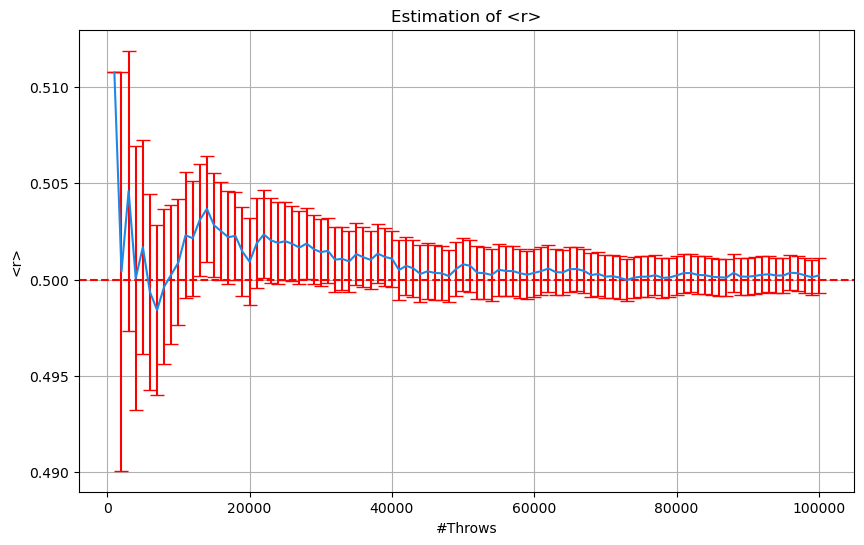

In [3]:
# Leggi i dati dal file
data = pd.read_csv('01.1/dataClass.dat',sep=' ', header=None)

# Estrai le colonne
x = data[0]
y = data[1]
yerr = data[2]

# Crea il grafico con barre di errore
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, color = '#1E88E5', ecolor='r', capsize=5)
plt.axhline(y=0.5, color='r', linestyle='--')
plt.xlabel('#Throws')
plt.ylabel('<r>')
plt.title('Estimation of <r>')
plt.grid(True)
plt.show()

This graph shows the trend of the progressive mean value of $\langle r \rangle$ and its error. The compatibility of $\langle r \rangle$ with its expected value can be observed.

Estimation of $\sigma^2$, with an expected value of $\frac{1}{12}$.  
To achieve this, I implemented the `UniformSigma` class in `Library/blockAverage/blockAverage.cpp`

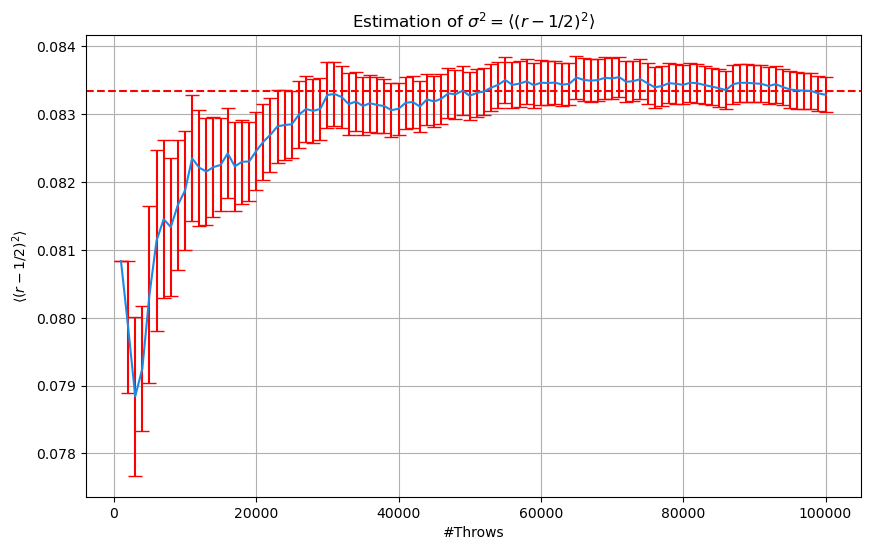

In [4]:
# Leggi i dati dal file
data = pd.read_csv('01.1/dataSigmaClass.dat', sep=' ', header=None)

# Estrai le colonne
x = data[0]
y = data[1]
yerr = data[2]

# Crea il grafico con barre di errore
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, color = '#1E88E5', ecolor='r', capsize=5)
plt.axhline(y = 1/12, color='r', linestyle='--')
plt.xlabel('#Throws')
plt.ylabel(rf'$\langle(r-1/2)^2\rangle$')
plt.title('Estimation of ' rf'$\sigma^2 = \langle(r-1/2)^2\rangle$')
plt.grid(True)
plt.show()

Now the estimation of $\chi^2$. To do this, I didn't create any class but did it directly in the `01/01.1/main.cpp` file. I created a scatter plot of the $\chi^2$ values and then a histogram of the same $\chi^2$ values. On this latter graph, I also performed a Gaussian fit to see where the mean value of $\chi^2$ was settling. Indeed, as explained in the theoretical treatment, a value of $\chi^2 \simeq 100$ is expected. As evidenced by the fit data reported in the legend, the obtained value is compatible within one $\sigma$ with the expected value.

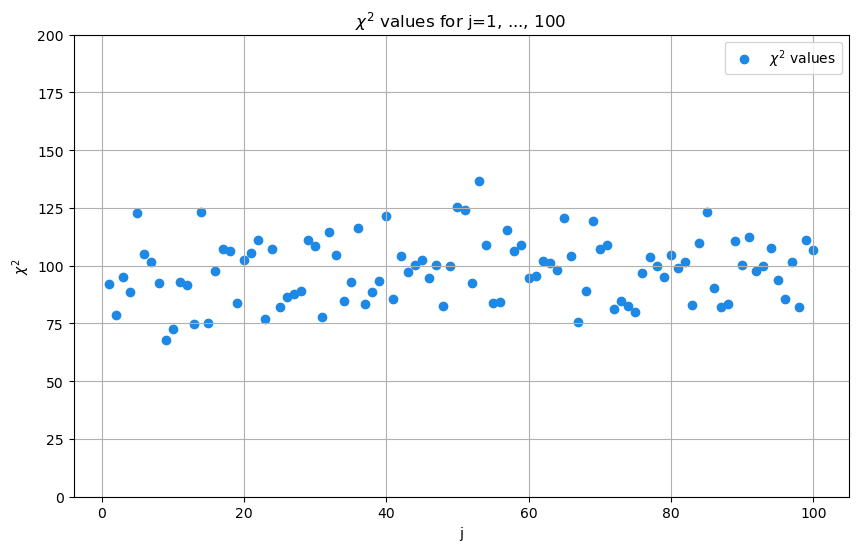

In [5]:
chi2_data = pd.read_csv('01.1/chi2Class.dat', sep=' ', header=None)
chi2_data.columns = ['j', 'chi2']

# Crea un grafico a dispersione
plt.figure(figsize=(10, 6))
plt.scatter(chi2_data['j'], chi2_data['chi2'], color = '#1E88E5', label=r'$\chi^2$ values')
plt.xlabel('j')
plt.ylabel(r'$\chi^2$')
plt.grid(True)
plt.title(r'$\chi^2$ values for j=1, ..., 100')
plt.ylim(0, 200)
plt.legend()
plt.show()

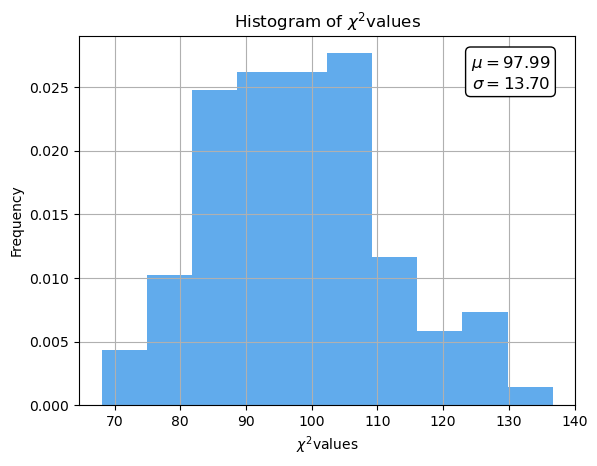

In [14]:
# Leggi i dati dal file chi2.dat
chi2_data = pd.read_csv('01.1/chi2Class.dat', sep=' ', header=None)
chi2_data.columns = ['j', 'chi2']

# Crea un istogramma dei valori della prima colonna
counts, bins, _ = plt.hist(chi2_data['chi2'], bins=10, color = '#1E88E5', alpha=0.7, density=True)

# Calcola il centro di ciascun bin
bin_centers = (bins[:-1] + bins[1:]) / 2


# Aggiungi etichette e titolo
plt.xlabel(r'$\chi^2$' 'values')
plt.ylabel('Frequency')
plt.grid(True)
plt.title('Histogram of 'r'$\chi^2$' 'values')
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
plt.text(0.95, 0.95, rf'$\mu={mu:.2f}$''\n' rf'$\sigma={sigma:.2f}$', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right',
         bbox=bbox_props)


# Mostra il grafico
plt.show()

To achieve better results regarding the Chi-squared (χ²) statistic, we should increase the sample size by generating more data.

## Exercise 01.2
In this exercise we have experimentally verified the statement shared by the family of Central Limit Theorems. For all of them, the assertion holds that the probability distribution of the (normalized) sum of a large number of random variables tends to a given regular distribution (attractor), which is normally the Gaussian or the Lorentzian.

To do this, I introduced in the ```Random``` class defined in `Library/PNRG/random.hpp` methods for generating numbers with a generic exponential distribution of the type $p(x) = \lambda \exp(-\lambda x)$, $x\in [0;+\infty]$ and for a generic Cauchy-Lorentz distribution $p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}$, $x\in [-\infty;+\infty]$

Subsequently, I generated three sets of graphs. Each graph represents $10^4$ realizations of $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ (for $N=1, 2, 10, 100$), being $x_i$ a random variable. In the fourth graph of each series, $N=100$, the convergence to the attractor is shown. In the case of the standard and exponential dice, it's the Gaussian, while for the Lorentzian dice, it's the Cauchy-Lorentz distribution itself.

To generate data arranged according to a specific distribution, I used the inverse function method, that is, by inverting the cumulative function.

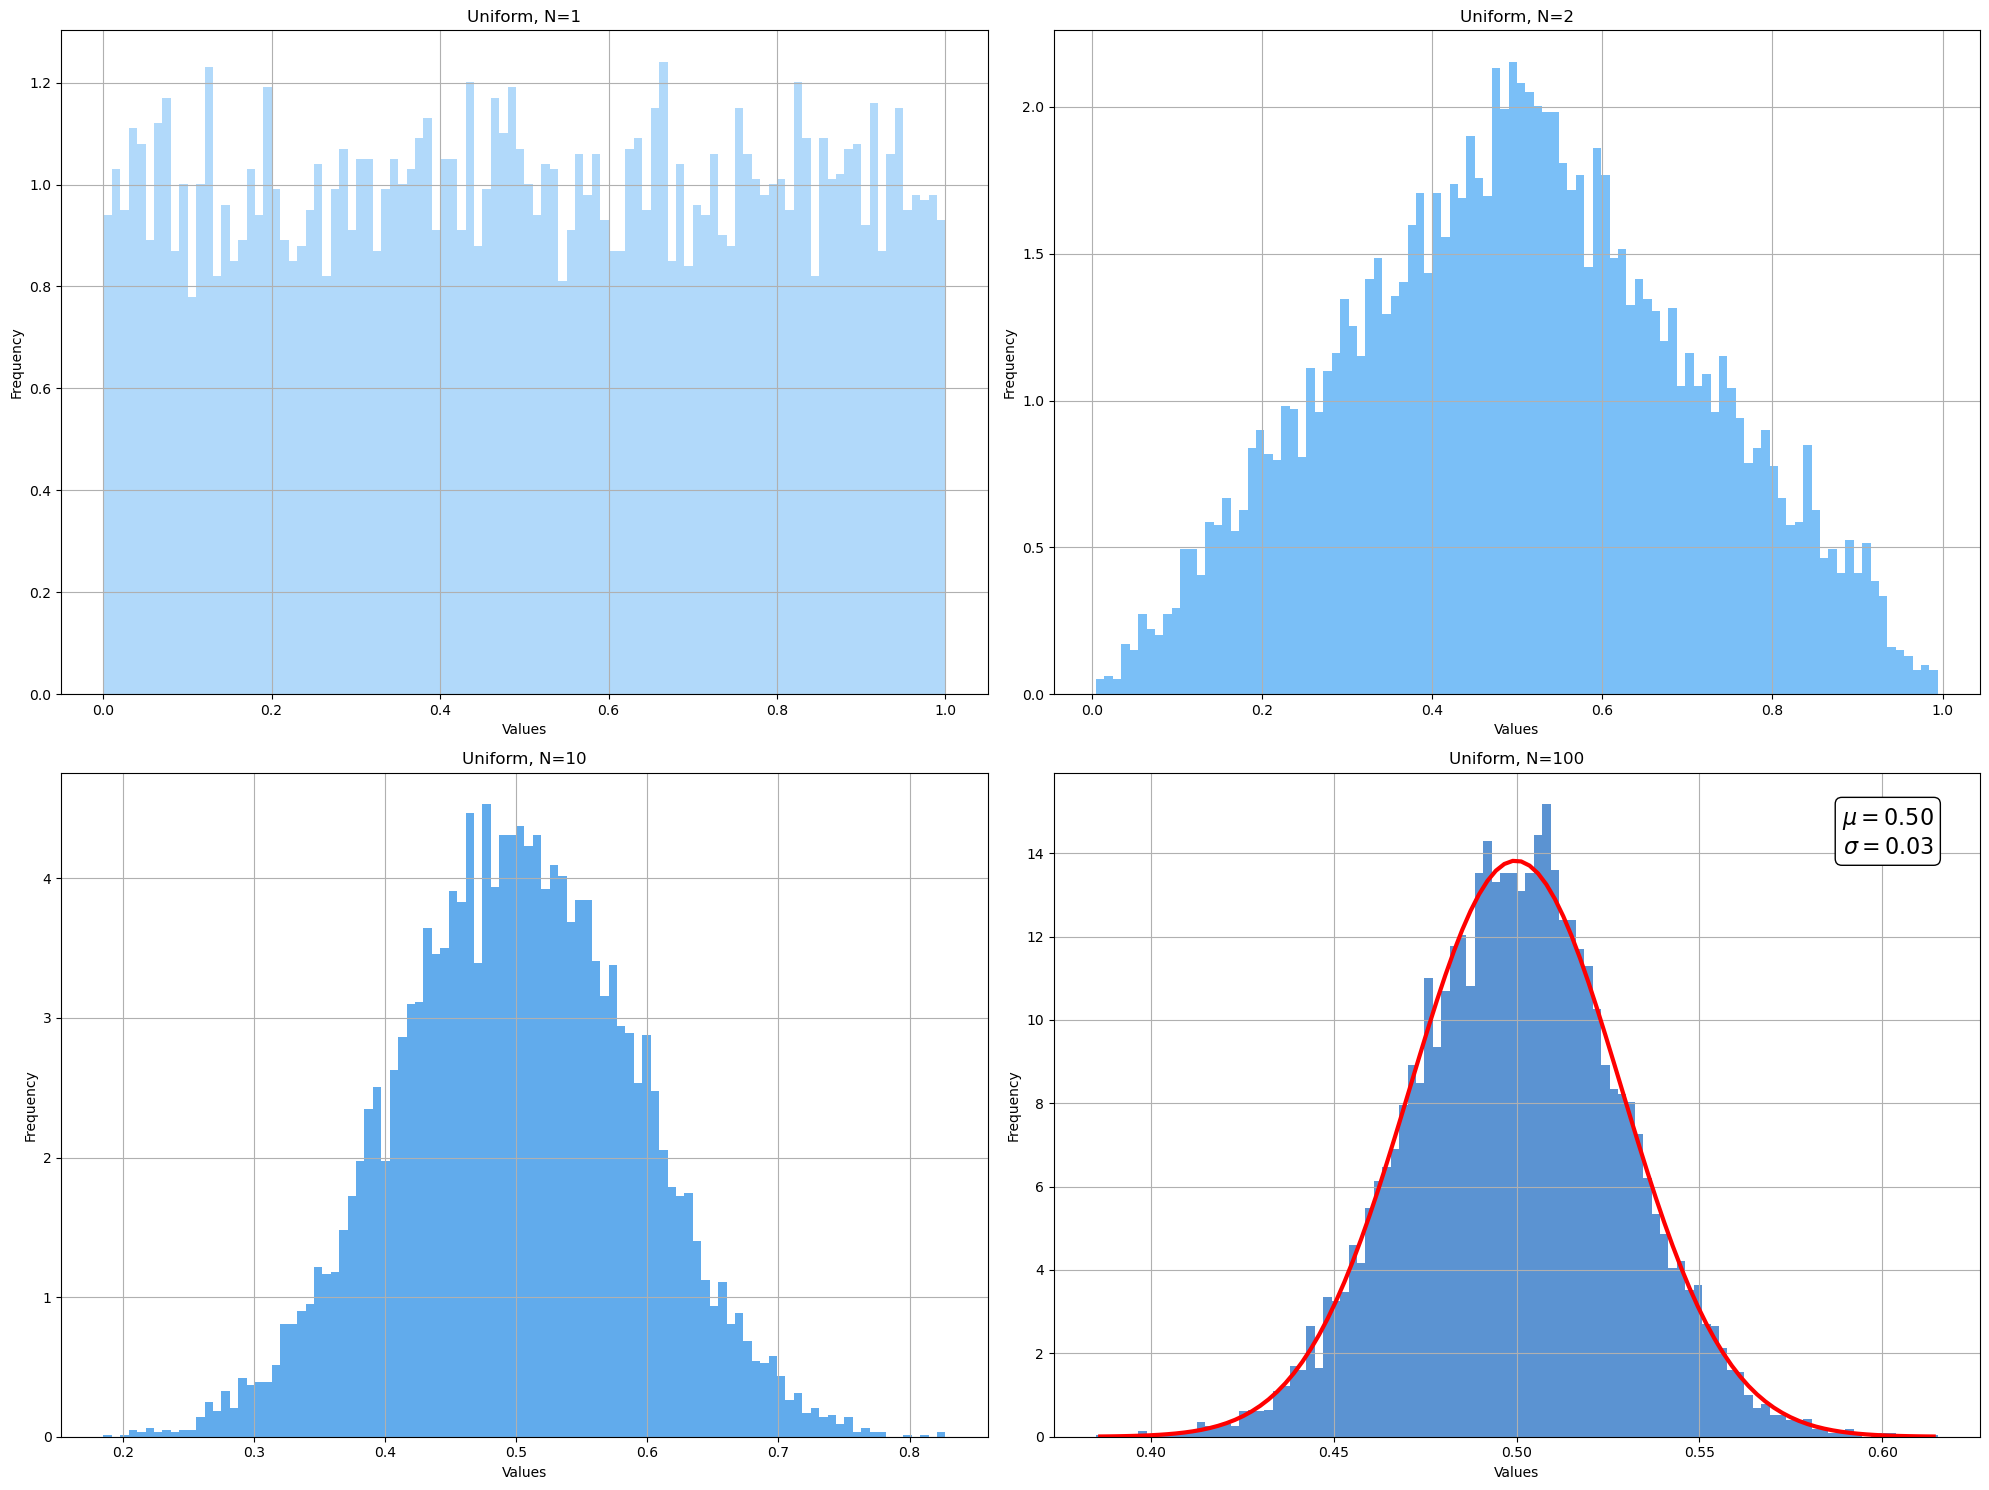

In [7]:
# Funzione per creare un istogramma con o senza fit gaussiano
def create_histogram(ax, data, column, title, color, fit_gaussian=False):
    # Crea l'istogramma
    counts, bins, _ = ax.hist(data[column], bins=100, color=color, alpha=0.7, density=True)
    
    if fit_gaussian:
        bin_centers = (bins[:-1] + bins[1:]) / 2
        (mu, sigma) = norm.fit(data[column])
        y = norm.pdf(bin_centers, mu, sigma)
        ax.plot(bin_centers, y, 'r', linewidth=3)
        # Parametri della distribuzione
        bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
        ax.text(0.95, 0.95, rf'$\mu={mu:.2f}$''\n'rf'$\sigma={sigma:.2f}$', 
                transform=ax.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right',
                bbox=bbox_props)
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.set_title(title)

# Leggi i dati dai file
data0 = pd.read_csv('01.2/output_0.dat', sep=' ', header=None)
data1 = pd.read_csv('01.2/output_1.dat', sep=' ', header=None)
data2 = pd.read_csv('01.2/output_2.dat', sep=' ', header=None)
data3 = pd.read_csv('01.2/output_3.dat', sep=' ', header=None)

# Crea i grafici
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# Crea istogrammi per ogni colonna dei file
create_histogram(axs[0, 0], data0, 0, 'Uniform, N=1', '#90CAF9')
create_histogram(axs[0, 1], data1, 0, 'Uniform, N=2', '#42A5F5')
create_histogram(axs[1, 0], data2, 0, 'Uniform, N=10', '#1E88E5')
create_histogram(axs[1, 1], data3, 0, 'Uniform, N=100', '#1565C0', fit_gaussian=True)

# Mostra i grafici
plt.tight_layout()
plt.show()

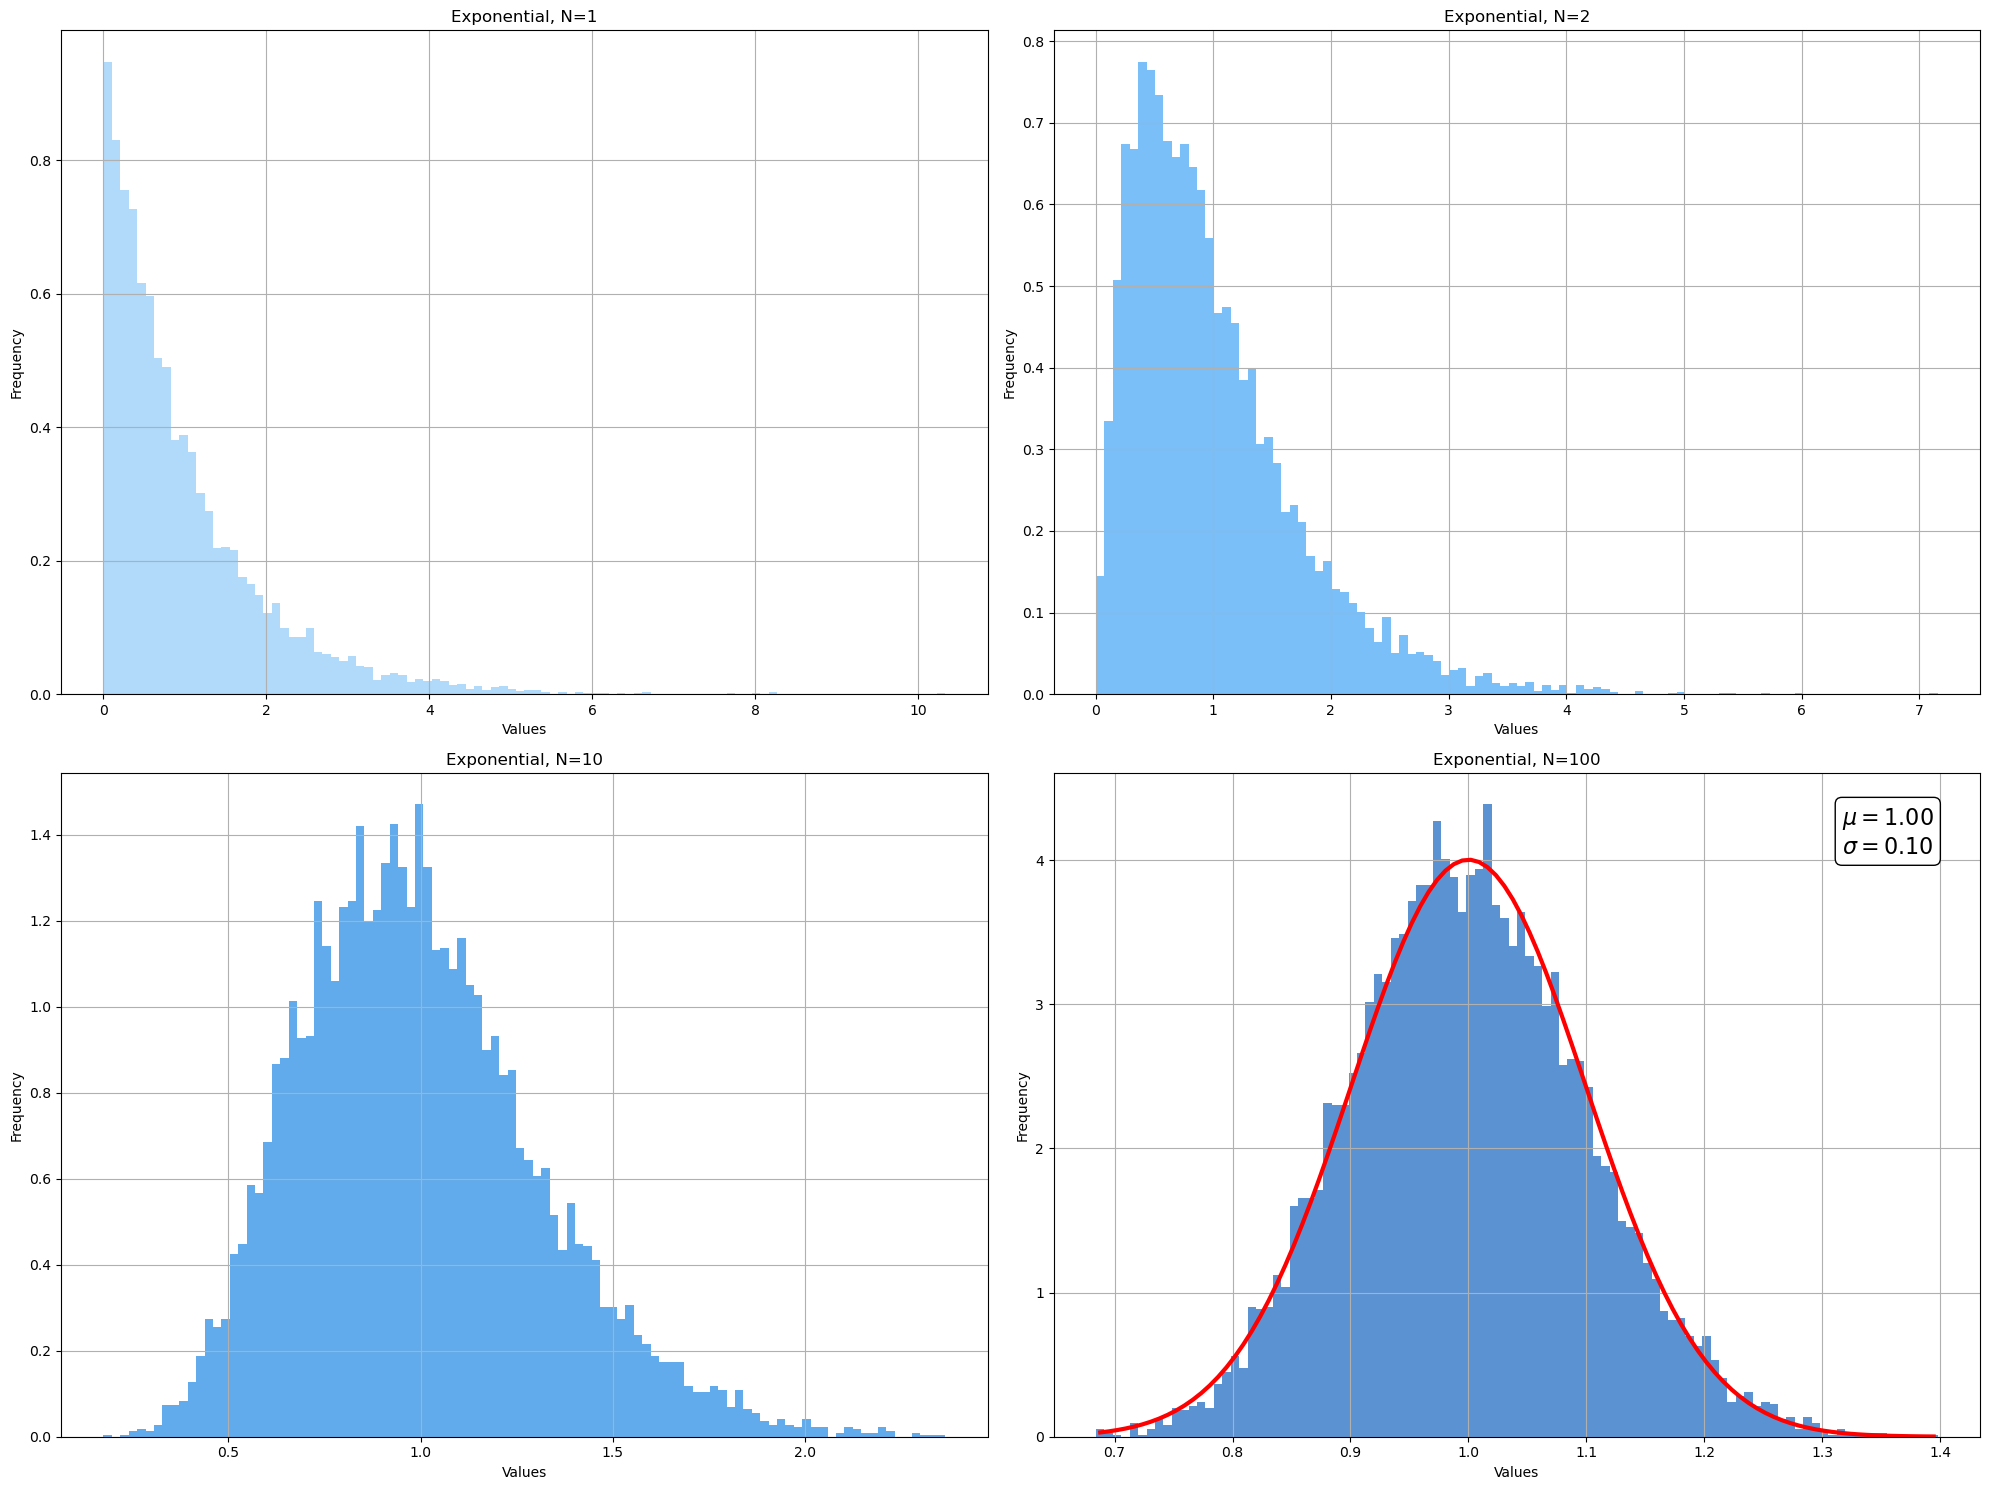

In [8]:
# Funzione per creare un istogramma con o senza fit gaussiano
def create_histogram(ax, data, column, title, color, fit_gaussian=False):
    # Crea l'istogramma
    counts, bins, _ = ax.hist(data[column], bins=100, color=color, alpha=0.7, density=True)
    
    if fit_gaussian:
        # Calcola il centro di ciascun bin
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # Esegui il fit con una distribuzione gaussiana
        (mu, sigma) = norm.fit(data[column])
        
        # Crea una distribuzione gaussiana con i parametri ottenuti
        y = norm.pdf(bin_centers, mu, sigma)
        
        # Sovrapponi il fit all'istogramma
        ax.plot(bin_centers, y, 'r', linewidth=3)
        
        # Aggiungi i parametri del fit al grafico
        bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white")
        ax.text(0.95, 0.95, rf'$\mu={mu:.2f}$''\n'rf'$\sigma={sigma:.2f}$', 
                transform=ax.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right',
                bbox=bbox_props)
    
    # Aggiungi etichette e titolo
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.set_title(title)

# Leggi i dati dai file
data0 = pd.read_csv('01.2/output_0.dat', sep=' ', header=None)
data1 = pd.read_csv('01.2/output_1.dat', sep=' ', header=None)
data2 = pd.read_csv('01.2/output_2.dat', sep=' ', header=None)
data3 = pd.read_csv('01.2/output_3.dat', sep=' ', header=None)

# Crea i grafici
fig, axs = plt.subplots(2, 2, figsize=(20, 15))

# Crea istogrammi per ogni colonna dei file
create_histogram(axs[0, 0], data0, 1, 'Exponential, N=1', '#90CAF9')
create_histogram(axs[0, 1], data1, 1, 'Exponential, N=2', '#42A5F5')
create_histogram(axs[1, 0], data2, 1, 'Exponential, N=10', '#1E88E5')
create_histogram(axs[1, 1], data3, 1, 'Exponential, N=100', '#1565C0', fit_gaussian=True)

# Mostra i grafici
plt.tight_layout()
plt.show()

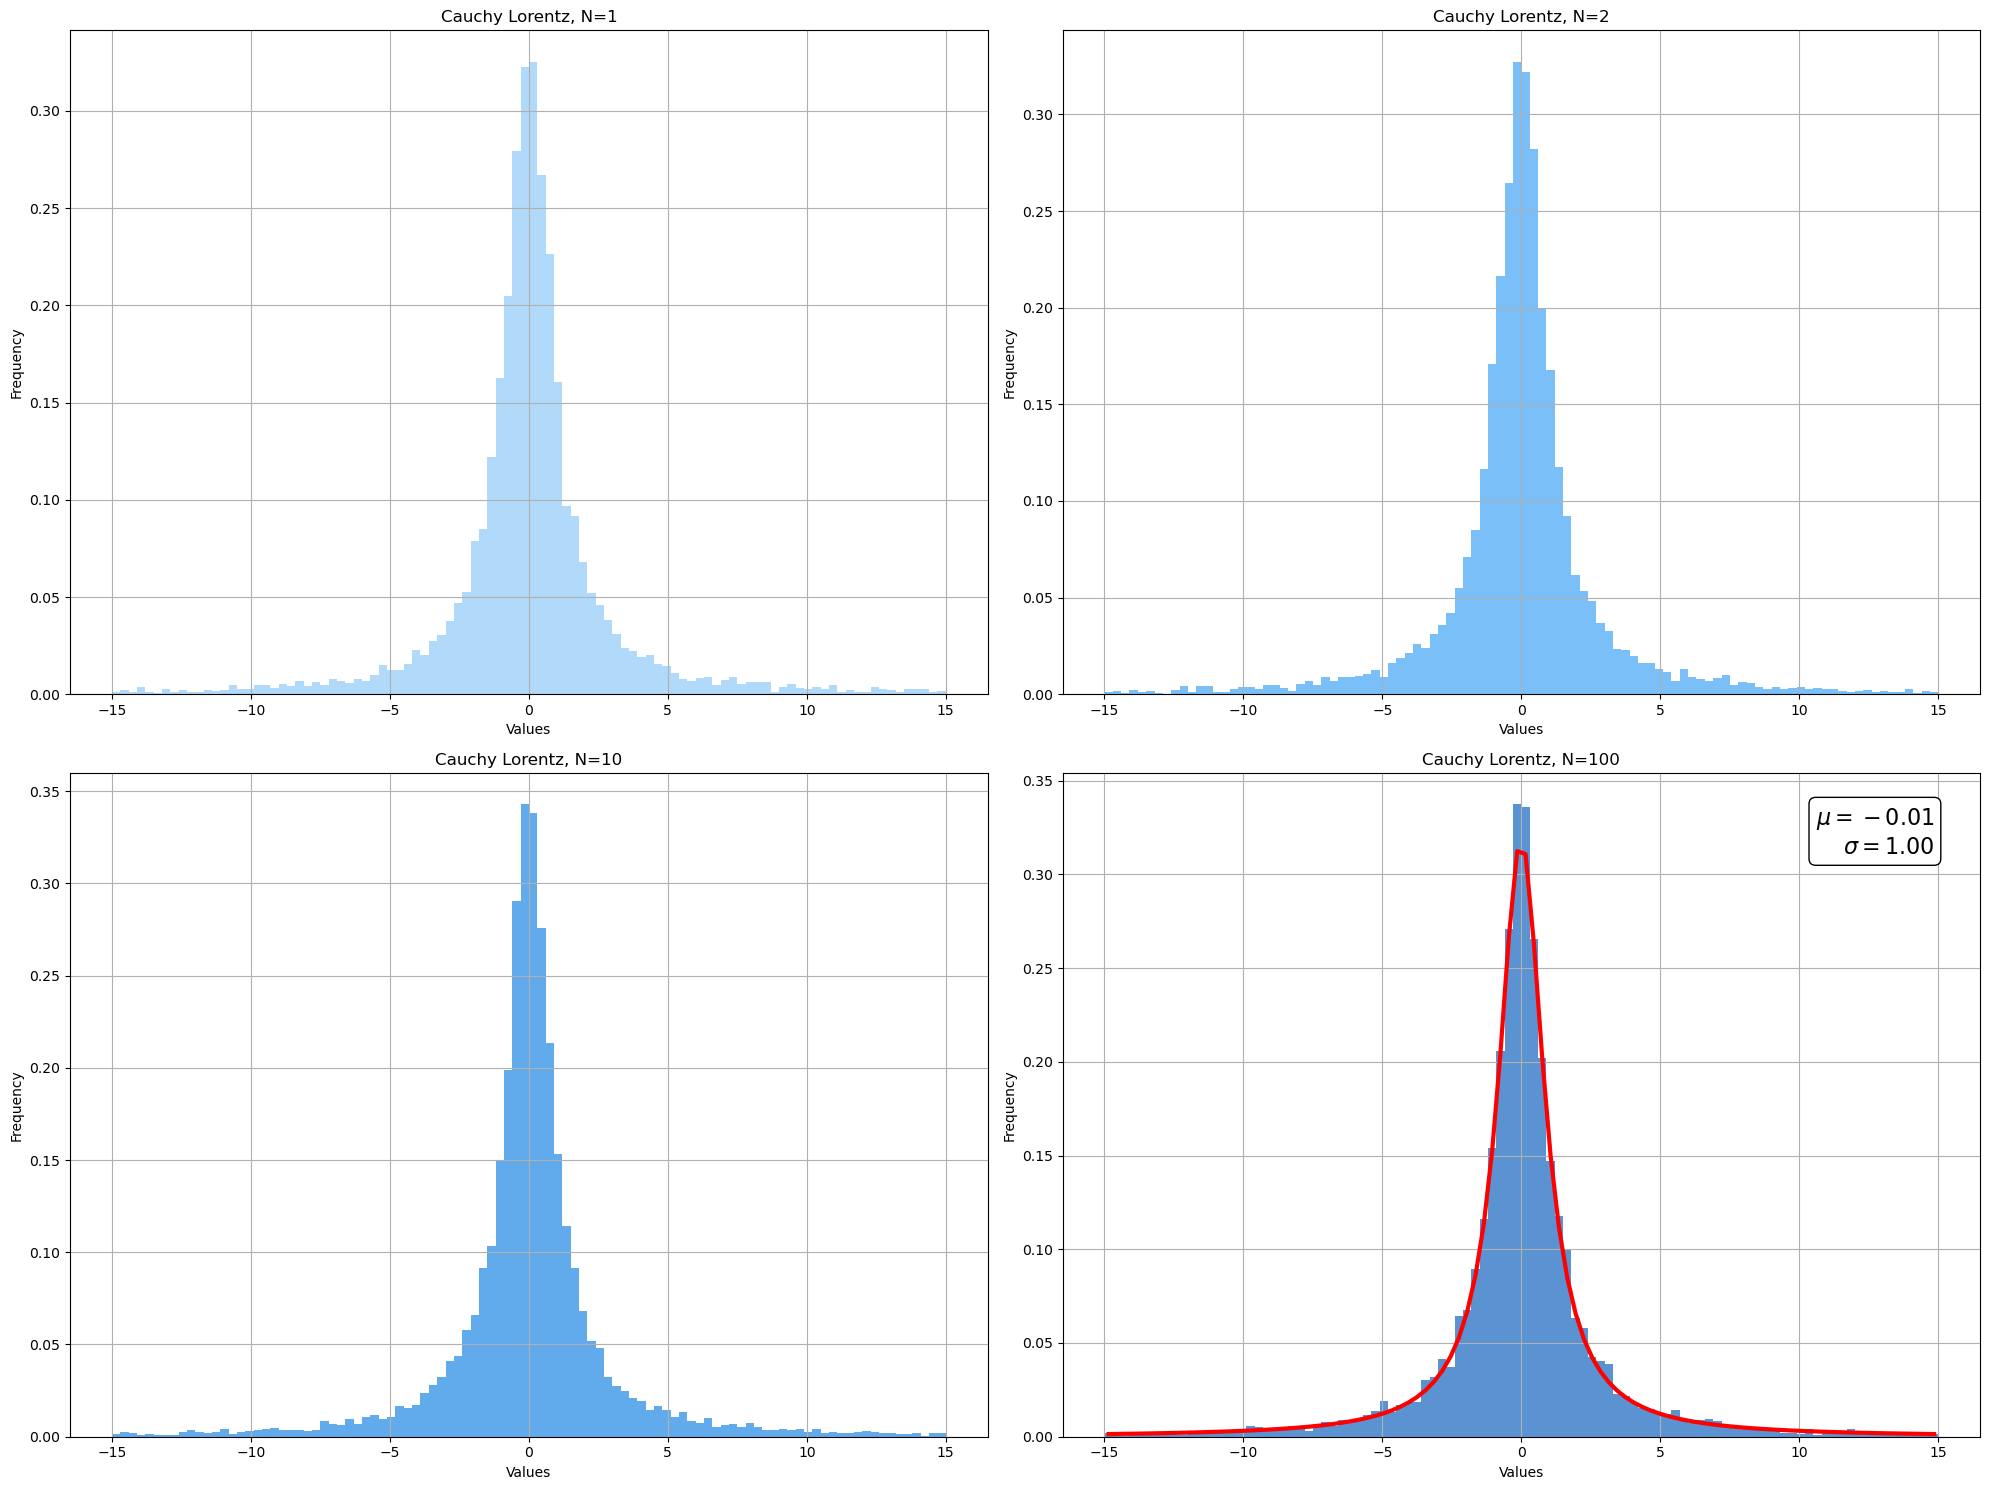

In [9]:
# Funzione per creare un istogramma con o senza fit
def create_histogram(ax, data, column, title, color, fit_type=None):
    counts, bins, _ = ax.hist(data[column], bins=100, color=color, alpha=0.7, density=True, range = (-15, 15))
    
    if fit_type == 'cauchy':
        bin_centers = (bins[:-1] + bins[1:]) / 2
        (loc, scale) = cauchy.fit(data[column])
        y = cauchy.pdf(bin_centers, loc, scale)
        ax.plot(bin_centers, y, 'r', linewidth=3)
        
        bbox_props = dict(boxstyle="round,pad=0.3", facecolor="white")
        ax.text(0.95, 0.95, rf'$\mu={loc:.2f}$''\n'rf'$\sigma={scale:.2f}$', 
                transform=ax.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='right',
                bbox=bbox_props)
    
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.set_title(title)

data0 = pd.read_csv('01.2/output_0.dat', sep=' ', header=None)
data1 = pd.read_csv('01.2/output_1.dat', sep=' ', header=None)
data2 = pd.read_csv('01.2/output_2.dat', sep=' ', header=None)
data3 = pd.read_csv('01.2/output_3.dat', sep=' ', header=None)

fig, axs = plt.subplots(2, 2, figsize=(20, 15))

create_histogram(axs[0, 0], data0, 2, 'Cauchy Lorentz, N=1', '#90CAF9')
create_histogram(axs[0, 1], data1, 2, 'Cauchy Lorentz, N=2', '#42A5F5')
create_histogram(axs[1, 0], data2, 2, 'Cauchy Lorentz, N=10', '#1E88E5')
create_histogram(axs[1, 1], data3, 2, 'Cauchy Lorentz, N=100', '#1565C0', fit_type='cauchy')

# Mostra i grafici
plt.tight_layout()
plt.show()

## Esercizio 01.3
Simulation of the Buffon's experiment. 

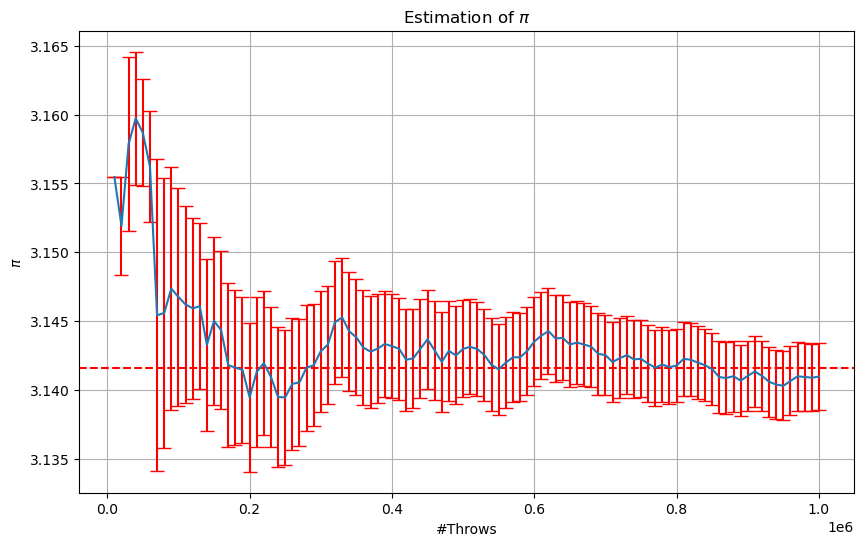

In [10]:
# Leggi i dati dal file
data = pd.read_csv('01.3/dataBuffonClass.dat',sep=' ', header=None)

# Estrai le colonne
x = data[0]
y = data[1]
yerr = data[2]

# Crea il grafico con barre di errore
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, ecolor='r', capsize=5)
plt.axhline(y=np.pi, color='r', linestyle='--', label=r'$\pi$')
plt.xlabel('#Throws')
plt.ylabel(r'$\pi$')
plt.title('Estimation of 'rf'$\pi$')
plt.grid(True)
plt.show()

As we can see from this graph, the experimental value of π obtained through Buffon's experiment is compatible with the real value.